# CSE327 Homework 4
**Due date: 23:59 on Nov. 20, 2018 (Thuesday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 100 points. There is no bonus question for this homework. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
You will be using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [39]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 

import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, RMSprop

from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.svm import LinearSVC
import time


In [40]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
#for name in glob.glob('data/train/*'):
#    print(name[11:])
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
#     # norm data to zero-centered
#     mean_img = np.mean(np.array(data), 0)
#     data = data - mean_img
#     data = [data[i] for i in xrange(data.shape[0])]
    
    # augment data
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.seed(45)
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'Bedroom', 1: 'Coast', 2: 'Forest', 3: 'Highway', 4: 'Industrial', 5: 'InsideCity', 6: 'Kitchen', 7: 'LivingRoom', 8: 'Mountain', 9: 'Office', 10: 'OpenCountry', 11: 'Store', 12: 'Street', 13: 'Suburb', 14: 'TallBuilding'}


In [41]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

3000
50
Finish loading 60 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


Suburb


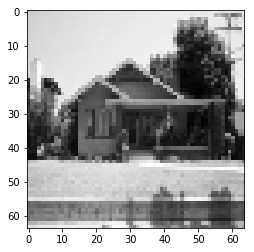

In [21]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [42]:
# ==========================================
#       Define Network Architecture
# ==========================================
# refered https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

class CNN(nn.Module):
    def __init__(self,input_ch,output_ch):
        super(CNN,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=input_ch,kernel_size=3,out_channels=output_ch,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=output_ch)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class CNN_Architecture(nn.Module):
    def __init__(self,num_classes=15):
        super(CNN_Architecture,self).__init__()
        
        #Create 5 layers of the unit with max pooling in between and dropout before last layer
        self.layer1 = CNN(1,32)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.layer2 = CNN(32, 64)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.layer3 = CNN(64, 128)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.layer4 = CNN(128, 128)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.dropout = nn.Dropout2d(0.5)
        
        self.layer5 = CNN(128, 256)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.network = nn.Sequential(self.layer1,self.pool1, self.layer2, self.pool2, self.layer3, 
                                     self.pool3, self.layer4, self.pool4, self.dropout, self.layer5,
                                     self.avg_pool)

        self.fixed_dimension = nn.Linear(in_features=256,out_features=num_classes)

    def forward(self, input):
        output = self.network(input)
        output = output.view(-1,256)
        output = self.fixed_dimension(output)
        return output

In [43]:
# ==========================================
#         Optimize/Train Network
# ==========================================

model = CNN_Architecture(num_classes= 15)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

def train(model, loss_function, optimizer, dataloader, num_epochs):
    for epoch in range(num_epochs):
        print('Starting epoch number %d' % (epoch + 1))
        train_loss = 0.0
        train_acc = 0.0
        model.train()
        for step_num, tup in enumerate(dataloader):
            
            x_var = Variable(tup[0])
            y_var = Variable(tup[1].long())
            optimizer.zero_grad()
            output_scores = model(x_var)
            
            loss = loss_function(output_scores, y_var)
            if (step_num + 1) % 25 == 0:
                print('step = %d, loss = %.4f' % (step_num + 1, loss.data.item()))

            
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.item() #* tup[0].size(0)
            _, prediction = torch.max(output_scores.data, 1)
            
            train_acc += torch.sum(prediction == tup[1])
        train_acc_epoch = (float(train_acc)/3000)*100
        print("Epoch {}, Train Accuracy: {} ".format(epoch+1, train_acc_epoch))
                        


# =========================================
#            Evaluating Network
# ==========================================
def evaluate(model, testloader_small):
    model.eval()
    test_acc = 0.0
    for step_num, tup in enumerate(testloader_small):
        test_output = model(tup[0])
        _, prediction = torch.max(test_output.data, 1)
        test_acc += torch.sum(prediction == tup[1])
        
    test_acc = (float(test_acc) / 1500)*100
    print("Got Test Accuracy of : {}".format(test_acc))
     
model.cpu()
model.train()
start = time.time()
train(model, loss_function, optimizer, trainloader_small, num_epochs=40)
end = time.time()
print( "time taken to train CNN classifier is %.2f secs" % (end-start))

start = time.time()
evaluate(model, testloader_small)
end = time.time()
print( "time taken to test CNN classifier is %.2f secs" % (end-start))

Starting epoch number 1
step = 25, loss = 2.3075
step = 50, loss = 2.0262
Epoch 1, Train Accuracy: 25.1 
Starting epoch number 2
step = 25, loss = 1.8182
step = 50, loss = 1.6159
Epoch 2, Train Accuracy: 45.13333333333333 
Starting epoch number 3
step = 25, loss = 1.7052
step = 50, loss = 1.2922
Epoch 3, Train Accuracy: 51.6 
Starting epoch number 4
step = 25, loss = 1.5165
step = 50, loss = 1.3531
Epoch 4, Train Accuracy: 55.400000000000006 
Starting epoch number 5
step = 25, loss = 1.4332
step = 50, loss = 1.1924
Epoch 5, Train Accuracy: 61.93333333333333 
Starting epoch number 6
step = 25, loss = 1.2437
step = 50, loss = 1.1241
Epoch 6, Train Accuracy: 66.16666666666666 
Starting epoch number 7
step = 25, loss = 1.2925
step = 50, loss = 0.9938
Epoch 7, Train Accuracy: 67.80000000000001 
Starting epoch number 8
step = 25, loss = 1.0916
step = 50, loss = 0.9581
Epoch 8, Train Accuracy: 70.63333333333334 
Starting epoch number 9
step = 25, loss = 1.0760
step = 50, loss = 0.7858
Epoch 9

My CNN network is 5 layers network each layer having a convolution unit followed by relu and batch2d normalization. Between all convolution layers I have added a maxpooling layer and before the last layer I have placed a drop out layer for regularization.

The first layer's convolution unit has 1 input channel for grey scale image and an out channel of 32. 
The second layer's convolution unit has 32 input channel for grey scale image and an out channel of 64.
The third layer's convolution unit has 64 input channel for grey scale image and an out channel of 128.
The fourth layer's convolution unit has 128 input channel for grey scale image and an out channel of 128.
The fifth layer's convolution unit has 128 input channel for grey scale image and an out channel of 256. 

Between each of theses layers the maxpool layer has a kernel of shape 2.
The optimizer I used for training is Adam as it converges faster than SGD and gives better results.

CNN's tend to overfit easily to train dataset in order to avoid this we increase train set.
Train set has beeen doubled by using mirroring as it ideally increases the number of train instances without adding unwanted ramndomness. The left-right flip increses the robustness of the image while keeping the important chatacterestics or features same.

In addition to data augmentation we also perform normalization of entire data set. This is different from per image normalization and per batch normalization. This helps to center entire dataset so that simillar parameters can be applied thoroughout the image.

To each Unit of CNN I added a Relu activation function and 2d BatchNormalisation.

BatchNormalisation greately affects the entire neural network. Ideally Batch normalization makes sure that the gradients do not reduce to low minimum and stay in same range across all batches. In all batch normalization is used to make layer wise learning for neural network easier. 

I started with Relu as they are faster than tanh an sigmoid activation functions and converge more easily.

Without dropout:
I initially trained the network with above configuration without the dropout regularization. 

The train loss at went down very quickly and the train accuracy increased quickly. This generally points to network getting overfitted easily. 

Adding dropout before last layer with dropout rate of 0.5 percent during training phase helps to drop hidden or visible neurons. That is it forces the neural network to learn more combinations of neurons hence ideally we should let the neiral network learn for double the time with drop out layer.

So the train accuracy started with 27% instead of starting with 37% and the loss reduced very slowly. 

To try out different activation functions I used 25 epochs with above mentioned network now even including dropout layer and the comparisons are as follows:

**Sigmoid:**

Starting epoch number 25
step = 25, loss = 1.3512
step = 50, loss = 1.0140

Epoch 25, Train Accuracy: 58.4 
time taken to train CNN classifier is 937.24 secs

Got Test Accuracy of : 17.4
time taken to test CNN classifier is 7.66 secs

**Tanh:**

Starting epoch number 25
step = 25, loss = 0.3114
step = 50, loss = 0.1360

Epoch 25, Train Accuracy: 95.73333333333333 
time taken to train CNN classifier is 883.32 secs

Got Test Accuracy of : 60.6
time taken to test CNN classifier is 7.37 secs

**Relu:**

Starting epoch number 25
step = 25, loss = 0.3146
step = 50, loss = 0.0993

Epoch 25, Train Accuracy: 94.5 
time taken to train CNN classifier is 823.32 secs

Got Test Accuracy of : 61.6
time taken to test CNN classifier is 7.25 secs

**Leaky Relu:**

Starting epoch number 25
step = 25, loss = 0.1999
step = 50, loss = 0.2268

Epoch 25, Train Accuracy: 94.06666666666666 
time taken to train CNN classifier is 964.68 secs

Got Test Accuracy of : 55.266666666666666
time taken to test CNN classifier is 7.89 secs

As seen above the Relu performed best. Also the time taken changes a lot and sigmoid takes the most to train followed by tanh and then Relu. Relu ideally takes max(0, val) and is less complicated than other activation functions.

Finally I incresed the epochs to 40 with best activation function i. Relu.

**The time and accuracy of final network is:
Time taken to train CNN classifier is 1783.55 secs
Got Test Accuracy of : 66.66666666666666
Time taken to test CNN classifier is 10.44 secs
**


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [12]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

1500
50
Finish loading 30 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


In [45]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

alexnet_model = models.alexnet(pretrained=True)
ct = 0

for child in list(alexnet_model.classifier.children()):
    if ct < 4:
        for param in list(child.parameters()):
            param.requires_grad = False
    else:
        for param in list(child.parameters()):
            param.requires_grad = True
    ct += 1
    
ct = 0
for child in list(alexnet_model.features.children()):
    if ct < 4:
        for param in list(child.parameters()):
            param.requires_grad = False
    else:
        for param in list(child.parameters()):
            param.requires_grad = True
    ct += 1

alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 15)
loss_function = nn.CrossEntropyLoss()

#optimizer = Adam(alexnet_model.parameters(), lr=0.001, weight_decay=0.0001)

optimizer = RMSprop(alexnet_model.parameters(), lr = 1e-4)

def train_alexnet(model, loss_function, optimizer, dataloader, num_epochs):
    for epoch in range(num_epochs): 
        print('Starting epoch number %d' % (epoch + 1))
        train_loss = 0.0
        train_acc = 0.0
        model.train()
        for step_num, tup in enumerate(dataloader):
            
            x_var = Variable(tup[0])
            y_var = Variable(tup[1].long())
            optimizer.zero_grad()
            output_scores = model(x_var)
            
            loss = loss_function(output_scores, y_var)
            
            if (step_num+1)% 25 == 0:
                print("Train Loss")
                print('step = %d, loss = %.4f' % (step_num+1, loss.data.item()))

            
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().data.item() 
            _, prediction = torch.max(output_scores.data, 1)
            
            train_acc += torch.sum(prediction == tup[1])
        train_acc_epoch = (float(train_acc)/1500)*100
        print("Epoch {}, Train Accuracy: {}".format(epoch+1, train_acc_epoch))
                        


# ==========================================
#            Evaluating Network
# ==========================================
def evaluate_alexnet(model, testloader_large):
    model.eval()
    test_acc = 0.0
    test_loss = 0.0
    for step_num, tup in enumerate(testloader_large):
        test_output = model(tup[0])
        _, prediction = torch.max(test_output.data, 1)
        test_loss = loss_function(test_output, tup[1])
        test_acc += torch.sum(prediction == tup[1])       
    test_acc = (float(test_acc) / 1500)*100
    print("Got Test Accuracy of : {}".format(test_acc))

alexnet_model.cpu()
alexnet_model.train() 

start = time.time()
train_alexnet(alexnet_model, loss_function, optimizer, trainloader_large, num_epochs=13)
end = time.time()
print( "time taken to train alex_net fine tunned classifier is %.2f secs" % (end-start))

start = time.time()
evaluate(alexnet_model, testloader_large)
end = time.time()
print( "time taken to test alex_net fine tunned classifier is %.2f secs" % (end-start))

Starting epoch number 1
Train Loss
step = 25, loss = 0.8265
Epoch 1, Train Accuracy: 52.6
Starting epoch number 2
Train Loss
step = 25, loss = 0.5097
Epoch 2, Train Accuracy: 82.8
Starting epoch number 3
Train Loss
step = 25, loss = 0.2598
Epoch 3, Train Accuracy: 90.46666666666667
Starting epoch number 4
Train Loss
step = 25, loss = 0.2014
Epoch 4, Train Accuracy: 93.0
Starting epoch number 5
Train Loss
step = 25, loss = 0.0532
Epoch 5, Train Accuracy: 97.13333333333334
Starting epoch number 6
Train Loss
step = 25, loss = 0.1012
Epoch 6, Train Accuracy: 97.13333333333334
Starting epoch number 7
Train Loss
step = 25, loss = 0.0572
Epoch 7, Train Accuracy: 99.0
Starting epoch number 8
Train Loss
step = 25, loss = 0.0255
Epoch 8, Train Accuracy: 99.33333333333333
Starting epoch number 9
Train Loss
step = 25, loss = 0.1468
Epoch 9, Train Accuracy: 95.53333333333333
Starting epoch number 10
Train Loss
step = 25, loss = 0.0430
Epoch 10, Train Accuracy: 99.8
Starting epoch number 11
Train Lo

For this question I have replace the last layer of alexnet with nn.Linear layer with input channels equal to output of second last layer of alexnet. The output of last layer of updated alexnet will be 15 i.e equal to number of classes of our classifier task. 

Also for the Alexnet I made all the layers except tha last layer which we have changead as not trainable. That is the alexnet only trains on the last layer with our images earlier layers remain as they were trained with original big dataset of image net.

For this question I changed the optimizer to RMSprop from Adam giving an accuracy boost of 6% and trained foe 13 epochs.

For part 2 i.e svm-alexnet we completely remove the last layer and make all layers non-trainable and take the output of second last layer as features these are actually 4096 features I took only 500n out of those. 

In [46]:
alexnet_model = models.alexnet(pretrained=True)

for child in list(alexnet_model.classifier.children()):
        for param in list(child.parameters()):
            param.requires_grad = False
            
features = list(alexnet_model.classifier.children())[:-1]
alexnet_model.classifier = nn.Sequential(*features)

def get_features_alexnet(model, dataloader):
    svm_features = []
    svm_labels = []
    for step_num, tup in enumerate(dataloader):

        x_var = Variable(tup[0])
        y_var = Variable(tup[1].long())

        output_scores = model(x_var)

        svm_features.extend(np.array(output_scores.data[:][:500]))
        svm_labels.extend(np.array(y_var))
    
    return svm_features, svm_labels
def alexnet_svm_classifier(alexnet_model, trainloader_large, testloader_large):
    start = time.time()
    train_data, train_label = get_features_alexnet(alexnet_model, trainloader_large)
    chi2sampler = AdditiveChi2Sampler(sample_steps=2)
    X_transformed = chi2sampler.fit_transform(train_data, train_label)
    svm = LinearSVC(C=10) 
    svm.fit(X_transformed, train_label)
    end = time.time()
    
    print( "time taken to train alex_net svm classifier is %.2f secs" % (end-start))
    
    start = time.time()
    
    # test on trained svm model
    test_data, test_label = get_features_alexnet(alexnet_model, testloader_large)
    test_transformed = chi2sampler.fit_transform(test_data, test_label)
    predictions = svm.predict(test_transformed)
    accuracy = sum(np.array(predictions) == test_label) / float(len(test_data))
    print("The accuracy of Classifier is %.2f " % ((accuracy*100)))
    end = time.time()
    print("time taken to test alexnet svm classifier is %.2f secs" % ((end-start)))
    

alexnet_svm_classifier(alexnet_model, trainloader_large, testloader_large)
            



time taken to train alex_net svm classifier is 42.09 secs
The accuracy of Classifier is 81.20 
time taken to test alexnet svm classifier is 43.19 secs


with **last layer removed and feature set of  length 200** the accuracy and time is as follows: 

time taken to train alex_net svm classifier is 45.02 secs
The accuracy of Classifier is 79.53 %
time taken to test alexnet svm classifier is 45.75 secs

with **last three layers removed and feature set of  length 200** the accuracies and times are as follows:

time taken to train alex_net svm classifier is 44.10 secs
The accuracy of Classifier is 78.60 %
time taken to test alexnet svm classifier is 41.91 secs

**My current Svm-Alexnet model**

with last **layer removed and feature set of  length 500** the accuracy and time is as follows: 
time taken to train alex_net svm classifier is 42.09 secs
The accuracy of Classifier is 81.20 %
time taken to test alexnet svm classifier is 43.19 secs

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

<!--Write your report here in markdown or html-->
